# Notebook to setup the Active Optics algorithm
#### Load required libraries

In [4]:
import numpy as np
import logging
import pickle

from scipy import sparse
import scipy.linalg as la
from scipy.linalg import block_diag
import scipy.io as spio

import os
from os import path

from pathlib import Path

import matplotlib.pyplot as plt

# from ruamel import yaml
# from ruamel.yaml import YAML
# y = YAML()
# y.default_flow_style = None


#### Load Active Optics Calibration Matrix

In [5]:
# Folder of files with calibration matrices
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
# Number of bending modes
n_bm = 27
# Flag to include mount controllable modes
include_mount = False


In [6]:
# Load calibrations data
#dt = np.load(Path(calibDataFolder)/'calib_dt_SH0p5fluxTH_46BM.npz', allow_pickle=True)
#dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM_LoFi.npz', allow_pickle=True)

#M1-RBM
Dm1 = block_diag(*[Dseg[:,:6] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dm1 = block_diag(Dm1,dt['calibdt'][()]['D'][-1][:,:5])
#M2-RBM
Dm2 = block_diag(*[Dseg[:,6:12] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dm2 = block_diag(Dm2,dt['calibdt'][()]['D'][-1][:,5:10])
#M1BM
Dbm = block_diag(*[Dseg[:,12:12+n_bm] for Dseg in dt['calibdt'][()]['D'][:-1]])
Dbm = block_diag(Dbm,dt['calibdt'][()]['D'][-1][:,10:10+n_bm])

# Compute SH-WFS consolidated interaction matrix (FEM compatible ordering)
Dwfs = np.hstack((Dm1,Dm2,Dbm))

print("-> %dx%d interaction matrix was loaded successfully."%(Dwfs.shape[0],Dwfs.shape[1]))

# Include columns related to mount axes (AZ/EL)
if include_mount:
    dt_ = np.load(Path(calibDataFolder)/'piston_mount_calib_dt_end2end.npz', 
                 allow_pickle=True)
    Dwfs = np.hstack([Dwfs, dt_['calibdt'][()]['Dm']])
        

-> 7360x271 interaction matrix was loaded successfully.


Plot comparison of singular values with and without Mount axes

In [7]:
if (False) and include_mount:
    U,sigma,V = np.linalg.svd(Dwfs[:,:-2], full_matrices=False)        
    print('Weakest singular values :\n',sigma[-15:])
    U_,sigma_,V_ = np.linalg.svd(Dwfs, full_matrices=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,6))    
    plt.semilogy(sigma[:],'s-', label='wo mount')
    plt.semilogy(sigma_[:], 'd-.', label='with mount')
    plt.grid()
    plt.legend()
    plt.xlabel('# Mode')
    plt.ylabel('Dwfs singular values')
    plt.show()

Functions to compute controllable mode and control balance regularization matrices

In [18]:
def get_aco_recW2(Dwfs,wfsMask,DpwBM,rho_p,rho_s,**kwargs):

    try:
        plotPistonRegMat = kwargs['plotPistonRegMat']
    except:
        plotPistonRegMat = False

    if not ((Dwfs.shape[1]+2) % 7):
        mount_included = False
        n_bm = ((Dwfs.shape[1]+2)//7) - 12
    elif not ((Dwfs.shape[1]+2 -2) % 7):
        n_bm = ((Dwfs.shape[1])//7) - 12
        mount_included = True
    else:
        print('Unable to get the correct number of the calibrated bending modes. Check Dwfs!')

    # - - - Global clocking filtering: we assume that the last 12 modes refer to segment clocking
    n_r = 12
    _U,sigma,VT = np.linalg.svd(Dwfs,full_matrices=False)
    q = sigma[-n_r:]
    W2_clk = VT[-n_r:,:].T.dot(np.diag(q)).dot(VT[-n_r:,:])

     # - - - Segment piston penalization
    if mount_included:
        DpwBM = np.hstack([DpwBM, kwargs['Dp_az'], kwargs['Dp_el']])
        
    W2_piston = DpwBM.T.dot(DpwBM)

    if (plotPistonRegMat):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow(W2_piston[:6,:6], aspect='auto')
        plt.title('Segment Piston Penalization Matrix')
        plt.xlabel('Input mode'), plt.ylabel('Reconstructed mode')
        plt.show()

    if (False):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(8,4))
        plt.imshow((V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T), aspect='auto')
        plt.show()

    W2 = W2_clk + rho_p*W2_piston

    # Mean slope regularization
    if rho_s > 0.0:
        # - - - Mean slope removal matrices (but retains the overall contribution)
        O = np.kron(np.eye(6),np.ones((48*48,1)))
        V_pr = np.zeros((Dwfs.shape[0],6))
        for iv in range(6):
            V_pr[:,iv] = np.hstack([*[O[MaskSeg.ravel(),iv] for MaskSeg in wfsMask]])
        Lambda_pr = np.diag(1/np.sum(V_pr,axis=0))
        
        R_g = np.kron(np.eye(2),np.array([[1,1,1]]).T)
        Lambda_g = np.diag(1/np.sum(V_pr@R_g,axis=0))    
        S = np.matmul(V_pr @ (Lambda_pr - R_g@Lambda_g@R_g.T) @ V_pr.T, Dwfs)
        # Update W2 mean slope regularization matrix
        W2 += rho_s*S.T.dot(S)

    return W2


In [9]:
def get_aco_recW3(rho_rbm1,rho_rbm2,rho_Fz,**kwargs):
    
    W_M1TxyzRxyz = [rho_rbm1*i_cm for i_cm in [1]*6]
    W_M2TxyzRxyz = [rho_rbm2*i_cm for i_cm in [1]*6]
    
    W_rbm_oa = block_diag(np.diag(W_M1TxyzRxyz), np.diag(W_M2TxyzRxyz))
    W_rbm_cs = block_diag(np.diag(W_M1TxyzRxyz[:-1]), np.diag(W_M2TxyzRxyz[:-1]))
    # Rescale RBM weighting matrix
    rbm_factor = 1/np.linalg.norm(W_rbm_oa)

    # OA segment SA_F weights
    W_m1oaF = np.diag([1]*165)
    W_m1oaF =  rho_Fz*(1/np.linalg.norm(W_m1oaF))*W_m1oaF
    # CS (center segment) SA_F weights
    W_m1csF = np.diag([1]*154)
    W_m1csF =  rho_Fz*(1/np.linalg.norm(W_m1csF))*W_m1csF

    
    # Group weighting matrices
    W3_M1RBM = rbm_factor*block_diag(np.kron(np.eye(6),np.diag(W_M1TxyzRxyz)),
        np.diag(W_M1TxyzRxyz[:-1]))
    W3_M2RBM = rbm_factor*block_diag(np.kron(np.eye(6),np.diag(W_M2TxyzRxyz)),
        np.diag(W_M2TxyzRxyz[:-1]))
    W3_M1BM = block_diag(np.kron(np.eye(6),W_m1oaF),W_m1csF)
    # Merge weighting matrices
    W3 = block_diag(W3_M1RBM,W3_M2RBM,W3_M1BM)

    if 'rho_m' in kwargs.keys():
        W3 = block_diag(W3,kwargs['rho_m']*np.eye(2))
    
    W3 = (1/np.linalg.norm(W3))*W3
    
    # Print reconstructor regularization weights
    if(1):
        np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
        
        aux = np.diag(W3)
        if include_mount:
            print('Mount weights:\n',aux[-2:])
    
        _wM1rbm,_wM2rbm,_wSA_F = np.split(aux,[41,82],axis=0)
        print('M1 TxyzRxyz weights:\n',_wM1rbm[:5],'...(%s entries)'%_wM1rbm.shape)
        print('M2 TxyzRxyz weights:\n',_wM2rbm[:5],'...(%s entries)'%_wM2rbm.shape)
        print('Fz weights:\n',_wSA_F[:5],'...')
        np.set_printoptions(formatter=None)

    return W3


#### AcO reconstructor+controller settings

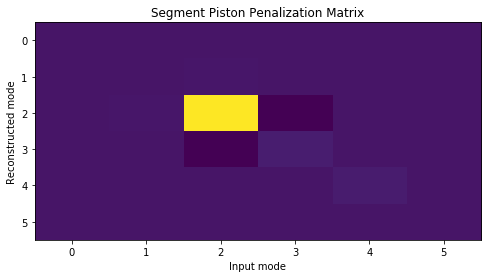

M1 TxyzRxyz weights:
 [ 0.151511  0.151511  0.151511  0.151511  0.151511] ...(41 entries)
M2 TxyzRxyz weights:
 [ 0.037878  0.037878  0.037878  0.037878  0.037878] ...(41 entries)
Fz weights:
 [ 0.000016  0.000016  0.000016  0.000016  0.000016] ...

Dimension of the vector of actuator limits:1228


In [21]:
# - - - - - - Maximmum actuator command values - - - - -
max_m1RBM = [3.0e-3,4.75e-3,4e-3] + [6.5e-4,5.75e-4,5.75e-4]
max_m2RBM = [3.0e-4,3.0e-4,3.0e-4] + [3.5e-3,3.5e-3,3.5e-3]
max_Fz = 147
max_az_el = [1e-2,1e-2]

# - - - - - - - - Get weighting matrices - - - - - - - -

dt_p = np.load(Path(calibDataFolder)/'piston_mount_calib_dt_end2end.npz', 
                 allow_pickle=True)
Dp = dt_p['calibdt'][()]['Dp']

if (Dp.shape[1] == 82):
    # Include zero columns corresponfing to bending modes 
    DpwBM = np.hstack([Dp, np.zeros((Dp.shape[0],7*n_bm))])
else:
    print('There is an unexpected number of columns in Piston calibration matrix Dp!')

# AcO configuration parameters
rho_p = 1.0e-3 #1.0e-4 #5.0e-4 #5.0e-6
rho_s = 0.0*1.0e-8
rho_rbm1 = 4
rho_rbm2 = 1
rho_Fz = 0.1*(12/165)**2
rho_m = 50
if include_mount:
    Dp_az = dt_p['calibdt'][()]['Dp_az']
    Dp_el = dt_p['calibdt'][()]['Dp_el']
    W2 = get_aco_recW2(Dwfs,dt['calibdt'][()]['wfsMask'],
        DpwBM=DpwBM,rho_p=rho_p,rho_s=rho_s,Dp_az=Dp_az,Dp_el=Dp_el)
    W3 = get_aco_recW3(rho_rbm1=rho_rbm1,rho_rbm2=rho_rbm2,rho_Fz=rho_Fz,rho_m=rho_m)
else:
    W2 = get_aco_recW2(Dwfs,dt['calibdt'][()]['wfsMask'],
        DpwBM=DpwBM,rho_p=rho_p,rho_s=rho_s,plotPistonRegMat=True)
    W3 = get_aco_recW3(rho_rbm1=rho_rbm1,rho_rbm2=rho_rbm2,rho_Fz=rho_Fz)

# Bending modes' data
# M1 influence matrix folder
Af_folder = '/Users/rromano/Workspace/GMTDataFiles/20200319 Rodrigo k6rot 100000 c'
Afz = {}
# OA segment weights
filename = os.path.join(Af_folder,'m1s1_Af.mat')
Afz['outer'] = spio.loadmat(filename)['afprime']
_U,s_oa,V_oaT = np.linalg.svd(Afz['outer'],0)
bm2Fz_oa = np.dot(V_oaT.T, np.diag(1/s_oa)[:,:n_bm])
# CS (center segment) weights
filename = os.path.join(Af_folder,'m1s7_Af.mat')
Afz['center'] = spio.loadmat(filename)['afprime']
_U,s_cs,V_csT = np.linalg.svd(Afz['center'],0)
bm2Fz_cs = np.dot(V_csT.T, np.diag(1/s_cs)[:,:n_bm])

# Transformation matrix from ctrlb modes to actuator action domain
fz_factor = np.mean(max_m1RBM + max_m2RBM)/max_Fz
_Tu = block_diag( np.eye(84), np.kron(np.eye(6),fz_factor*bm2Fz_oa), fz_factor*bm2Fz_cs)
_TuwoS7Rz = block_diag( np.eye(82), np.kron(np.eye(6),fz_factor*bm2Fz_oa), fz_factor*bm2Fz_cs)
# Actuator ranges [M1_RBM;M2_RBM;M1_SA_F]
rbm_ranges = max_m1RBM*7 + max_m2RBM*7
u_ranges = rbm_ranges + [fz_factor*max_Fz]*bm2Fz_oa.shape[0]*6 + [fz_factor*max_Fz]*bm2Fz_cs.shape[0]
print('\nDimension of the vector of actuator limits:%d'%len(u_ranges))

# Control action upper limits vector
umax = np.array(u_ranges) # np.array([]) # 
    
if include_mount:
    _Tu = block_diag(_Tu,np.eye(2))
    _TuwoS7Rz = block_diag(_TuwoS7Rz,np.eye(2))
    umax = np.hstack([umax, np.array(max_az_el)]) # np.array([]) #

# AcO integral controller gain
k_I = 0.5

# Active Optics dictionary data
W3 = _TuwoS7Rz.T @ W3 @ _TuwoS7Rz
data = {'SHAcO_qp':{'D':Dwfs,'W2':W2,'W3':W3,'K':k_I,
                    'wfsMask':dt['calibdt'][()]['wfsMask'],
                    'umin':-umax, 'umax':umax,'rm_mean_slopes':True,
                    '_Tu':_Tu, 'rho_3':1.0e-1, 'end2end_ordering':True}} #'J1_J3_ratio':10

# filename = 'SHAcO_qp.pickle'
filename = 'SHAcO_qp_rhoP1e-3_kIp5.pickle'
# filename = 'simpleSHAcO_qp.pickle'
# Pickles MPC data into string representation
with open(filename,'wb') as f:
    pickle.dump(data,f)
    

Check conditioning improvement due to regularization

In [11]:
condDTD = np.linalg.cond(Dwfs.T.dot(Dwfs))
print('Condition number improvement:\n')
print('Due to W2:',condDTD/np.linalg.cond(Dwfs.T.dot(Dwfs)+W2))
print('Due to W2 and W3:',condDTD/np.linalg.cond(Dwfs.T.dot(Dwfs)+W2+5.0e-7*k_I*W3*k_I))

Condition number improvement:

Due to W2: 50311.34025321038
Due to W2 and W3: 52477.08196944761


Cells to evaluate the AcO reconstructor

In [19]:
def plot_AcO_RdotD(RD,m1_cmap='Spectral'):
    plt.figure(figsize=(14,5))
    # M1 modes
    plt.subplot(1,2,1)
    m1RD = RD[:42,:42]
    pcm1 = plt.imshow(m1RD,cmap=plt.get_cmap(m1_cmap))
    plt.colorbar(pcm1,label='Contribution (Gain)')
    plt.title('M1 reconstruction')
    cn = 4
    for k in range(6):
        plt.axhspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        plt.axhspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        
    labelsDT = [plt.text(x+1.5,42,f'S{(k % 7)+1}',verticalalignment='top',fontweight='bold') 
                for k,x in enumerate(range(0,42,6),0)]            
    labelsDT = [plt.text(-3.5,y+4,f'S{(k % 7)+1}',horizontalalignment='left',fontweight='bold') 
                for k,y in enumerate(range(0,42,6),0)]
    plt.yticks(np.arange(0,42,6),labels = []); plt.xticks(np.arange(0,42,6),labels = [])  

    # M2 modes
    plt.subplot(1,2,2)
    m2RD = RD[42:84,42:84]
    pcm2=plt.imshow(m2RD,vmax=np.max(m2RD),vmin=-np.max(m2RD),cmap=plt.get_cmap('Spectral'))
    plt.colorbar(pcm2,label='Contribution (Gain)')
    plt.title('M2 reconstruction')
    for k in range(6):
        plt.axhspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*k,6*(k+1), color=f'C{(k%2)+cn}', alpha=0.1)
        plt.axvspan(6*(k+1),6*(k+1),color=f'C{cn}', alpha=0.3)
        plt.axhspan(6*(k+1),6*(k+1), color=f'C{cn}', alpha=0.3)
        
    labelsDT = [plt.text(x+1.5,42,f'S{(k % 7)+1}',verticalalignment='top',fontweight='bold') 
                for k,x in enumerate(range(0,42,6),0)]            
    labelsDT = [plt.text(-3.5,y+4,f'S{(k % 7)+1}',horizontalalignment='left',fontweight='bold') 
                for k,y in enumerate(range(0,42,6),0)]
    plt.yticks(np.arange(0,42,6),labels = []); plt.xticks(np.arange(0,42,6),labels = [])
    # OA & CS Segments
    plt.figure(figsize=(14,3))

    titles = ['M1-S1(OA)','M1-S7(CS)','M2-S1(OA)','M2-S7(CS)']
    ticklabels = ['Tx','Ty','Tz','Rx','Ry','Rz']
    res = [RD[:6,:6],RD[36:42,36:42],RD[42:48,42:48],RD[78:84,78:84]]
    vlim = [np.max(m1RD),np.max(m2RD)]
    for k in range(4):
        plt.subplot(1,4,k+1)
        plt.imshow(res[k],vmax=vlim[np.int(k/2)],vmin=-vlim[np.int(k/2)],cmap=plt.get_cmap('Spectral'))
        plt.title(titles[k])
        for k in range(6):
            plt.axvspan((k+.45),(k+.45),color=f'C{cn}', alpha=0.2)
            plt.axhspan((k+.45),(k+.45), color=f'C{cn}', alpha=0.2)
        labelsDT = [plt.text(x-0.3,5.8,ticklabels[kk],verticalalignment='top',fontweight='bold') 
                for kk,x in enumerate(range(0,6),0)]            
        labelsDT = [plt.text(-1.35,y+.15,ticklabels[kk],horizontalalignment='left',fontweight='bold') 
                for kk,y in enumerate(range(0,6),0)]
        plt.yticks(np.arange(6),labels = []); plt.xticks(np.arange(6),labels = [])

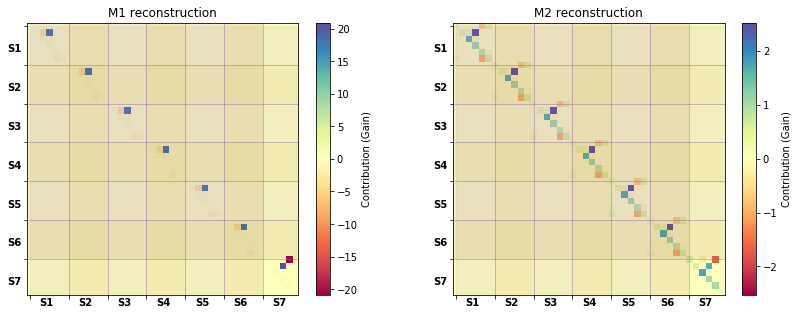

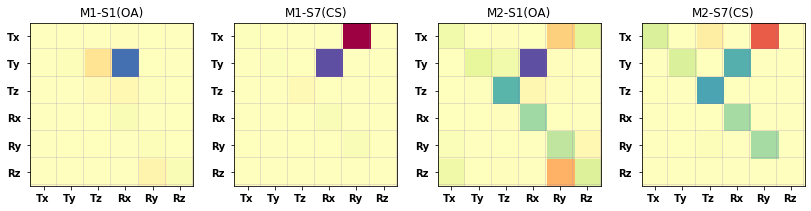

In [23]:
W2 = get_aco_recW2(Dwfs,dt['calibdt'][()]['wfsMask'],
        DpwBM=DpwBM,rho_p=1.0e-3,rho_s=rho_s)
# - - - NO Probe mean slope removal matrix Rs 
left_sym_inv = la.pinv(Dwfs.T.dot(Dwfs) + W2)
R = left_sym_inv.dot(Dwfs.T)
R = np.insert(R,[36+5,82],0,axis=0)

# Linear reconstruction bias
Dwfs_withS7Rz = np.hstack((Dm1,np.zeros((Dm1.shape[0],1)),Dm2,np.zeros((Dm1.shape[0],1)),Dbm))
RD = R.dot(Dwfs_withS7Rz)
plot_AcO_RdotD(RD)


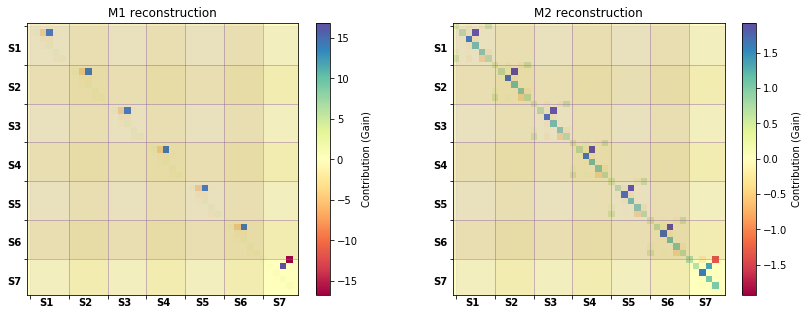

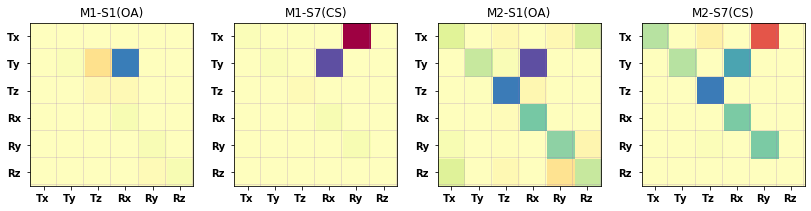

In [24]:
W2 = get_aco_recW2(Dwfs,dt['calibdt'][()]['wfsMask'],
        DpwBM=DpwBM,rho_p=1.0e-4,rho_s=rho_s)
# - - - NO Probe mean slope removal matrix Rs 
left_sym_inv = la.pinv(Dwfs.T.dot(Dwfs) + W2)
R = left_sym_inv.dot(Dwfs.T)
R = np.insert(R,[36+5,82],0,axis=0)

# Linear reconstruction bias
Dwfs_withS7Rz = np.hstack((Dm1,np.zeros((Dm1.shape[0],1)),Dm2,np.zeros((Dm1.shape[0],1)),Dbm))
RD = R.dot(Dwfs_withS7Rz)
plot_AcO_RdotD(RD)